In [16]:
#from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow.keras import layers

import pandas as pd
import numpy as np
import os

import librosa as l
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt
import imblearn

# Keras
import keras
import keras_metrics
from keras import regularizers
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from tensorflow.keras.optimizers import RMSprop

In [17]:
#%pip install keras_metrics

In [18]:
final_df = pd.read_csv('../Datasets/aug_final_df.csv')

# drop first column
#final_df.drop('Unnamed: 0', axis='columns', inplace=True)

# train-test split dataset
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

final_df_testing = final_df.copy()
final_df_testing = shuffle(final_df_testing)

X = final_df_testing.drop(columns=['Path', 'Emotions'], axis=1)
y = final_df_testing['Emotions']
print(X.shape, y.shape)

(11682, 173) (11682,)


In [19]:
# Handle imbalance classes with SMOTE
from imblearn.over_sampling import SMOTE
from collections import Counter

smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X, y)

# Split your data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size=0.2, random_state=42)

print('Original dataset shape', Counter(y))
print('\n')
print('Resample dataset shape', Counter(y_smote))

Original dataset shape Counter({2: 1096, 6: 1096, 0: 1096, 4: 1096, 3: 1096, 5: 960, 12: 767, 8: 767, 14: 767, 11: 767, 10: 767, 13: 623, 7: 496, 1: 96, 15: 96, 9: 96})


Resample dataset shape Counter({7: 1096, 2: 1096, 5: 1096, 12: 1096, 6: 1096, 8: 1096, 0: 1096, 4: 1096, 14: 1096, 3: 1096, 11: 1096, 10: 1096, 13: 1096, 1: 1096, 15: 1096, 9: 1096})


In [20]:
X_train

,MFCC0,MFCC1,MFCC2,MFCC3,MFCC4,MFCC5,MFCC6,MFCC7,MFCC8,MFCC9,...,Mel124,Mel125,Mel126,Mel127,Tonnetz0,Tonnetz1,Tonnetz2,Tonnetz3,Tonnetz4,Tonnetz5
4216,-295.504438,28.954242,23.156821,14.335419,6.123487,1.833719,2.231273,-0.817576,0.170417,-1.779874,...,9.615181e-03,1.441907e-02,7.528371e-03,1.614808e-03,-0.077389,-0.044339,-0.105095,0.052058,-0.014510,-0.024009
13474,-255.241353,55.189144,17.120529,12.562094,3.229621,-0.177920,1.163526,-0.645851,-7.059923,-1.681388,...,1.494577e-03,1.462435e-03,1.512621e-03,1.558721e-03,0.013763,-0.031184,-0.055906,-0.021754,0.011737,0.011746
2344,-211.330738,32.461812,2.805621,5.218137,2.240944,0.577832,-1.746766,0.122227,-2.227942,3.238524,...,5.104655e-03,4.884764e-03,4.736381e-03,4.564848e-03,-0.015840,0.023868,0.000748,-0.002756,0.023681,-0.010351
15889,-431.799362,102.134273,42.530214,29.166523,1.968691,9.991253,3.883492,3.650224,-5.551132,-2.044332,...,1.158031e-05,1.108016e-05,1.198244e-05,1.266859e-05,-0.002017,-0.011380,-0.074481,-0.039064,0.014627,0.016539
15538,-520.175034,32.640203,7.264143,3.746216,1.560381,-1.154151,-3.700368,-6.671868,-8.788224,-5.526781,...,1.737318e-05,1.913924e-05,1.535132e-05,1.041977e-05,-0.011821,0.001017,0.006524,0.000371,-0.001591,-0.000696
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11284,-411.600719,38.608620,21.714290,10.032472,4.273448,4.858537,-0.004053,-2.967167,-6.877984,-4.988551,...,1.152945e-04,1.041580e-04,9.252051e-05,8.097701e-05,-0.069926,-0.014133,-0.133601,-0.066755,-0.018416,0.032763
11964,-725.245142,45.773288,1.368698,3.967344,2.885920,-8.395825,-17.539556,-12.825505,-2.624491,-0.961142,...,2.104266e-05,2.242204e-05,1.025373e-05,4.397493e-07,-0.032577,0.046649,0.017636,-0.023233,0.001912,-0.030067
5390,-449.133512,126.396161,20.363343,46.046575,-1.577046,13.412769,-13.828393,7.991962,-8.382476,4.439486,...,6.567628e-07,7.574610e-07,6.162575e-07,7.120064e-07,-0.023337,-0.028501,-0.032783,-0.007863,0.017355,0.014240
860,-251.721879,37.696352,6.894572,11.332120,6.225201,-0.227890,1.182020,3.398979,-1.043887,-4.021904,...,2.156350e-03,2.328970e-03,2.197802e-03,2.224747e-03,0.006184,0.013761,-0.065387,-0.017549,0.024975,-0.000190


In [21]:
#X_smote.shape[1], 1
X_smote.shape[1], 1

(173, 1)

In [22]:
model = tf.keras.Sequential()

model.add(layers.Conv1D(128, kernel_size=5, strides=1, # first convulational layer
                        padding="same", activation="relu",
                        input_shape=(X_smote.shape[1], 1))) 
#model.add(layers.MaxPool1D(pool_size=2, strides=2, padding="same"))

model.add(layers.Conv1D(64, kernel_size=5, strides=1,  # second convulational layer
                        padding="same", activation="relu"))
#model.add(layers.MaxPool1D(pool_size=2, strides=2, padding="same"))

model.add(layers.Flatten()) # flatten into a 1D array
model.add(layers.Dense(128, activation='relu')) # fully connected layer
model.add(layers.Dense(64, activation='relu')) # fully connected layer

model.add(layers.Dense(16, activation="softmax")) # output layer

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 173, 128)          768       
                                                                 
 conv1d_3 (Conv1D)           (None, 173, 64)           41024     
                                                                 
 flatten_1 (Flatten)         (None, 11072)             0         
                                                                 
 dense_3 (Dense)             (None, 128)               1417344   
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dense_5 (Dense)             (None, 16)                1040      
                                                                 
Total params: 1468432 (5.60 MB)
Trainable params: 1468

## Applying regularisation (Early Stopping) to monitor the model's performance on a separate validation dataset during training - If the validation loss did not improve after 10 epochs, the training will stop.

In [24]:
from tensorflow.keras import layers, models, callbacks

# Compile the model with appropriate Loss function
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0001), 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'],
              run_eagerly=True)

#sparse_categorical_crossentropy --> when targets are integer & suitable for multiclasses
#categorical_crossentropy --> when targets are one-hot encoded vectors (binary) 

# Regularisation - Define early stopping callback 
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1)

epochs = 100

history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_test,y_test), callbacks=[early_stopping]) 

Epoch 1/100

439/439 [==============================] - 20s 45ms/step - loss: 1.9091 - accuracy: 0.4073 - val_loss: 1.5977 - val_accuracy: 0.4974
Epoch 2/100
439/439 [==============================] - 19s 43ms/step - loss: 1.4470 - accuracy: 0.5356 - val_loss: 1.4168 - val_accuracy: 0.5362
Epoch 3/100
439/439 [==============================] - 19s 43ms/step - loss: 1.2871 - accuracy: 0.5766 - val_loss: 1.2821 - val_accuracy: 0.5869
Epoch 4/100
439/439 [==============================] - 19s 43ms/step - loss: 1.1926 - accuracy: 0.5937 - val_loss: 1.2503 - val_accuracy: 0.5904
Epoch 5/100
439/439 [==============================] - 19s 43ms/step - loss: 1.1319 - accuracy: 0.6104 - val_loss: 1.2069 - val_accuracy: 0.5944
Epoch 6/100
439/439 [==============================] - 19s 43ms/step - loss: 1.0891 - accuracy: 0.6242 - val_loss: 1.1789 - val_accuracy: 0.6049
Epoch 7/100
439/439 [==============================] - 19s 43ms/step - loss: 1.0501 - accuracy: 0.6364 - val_loss: 1.1414 - val_a

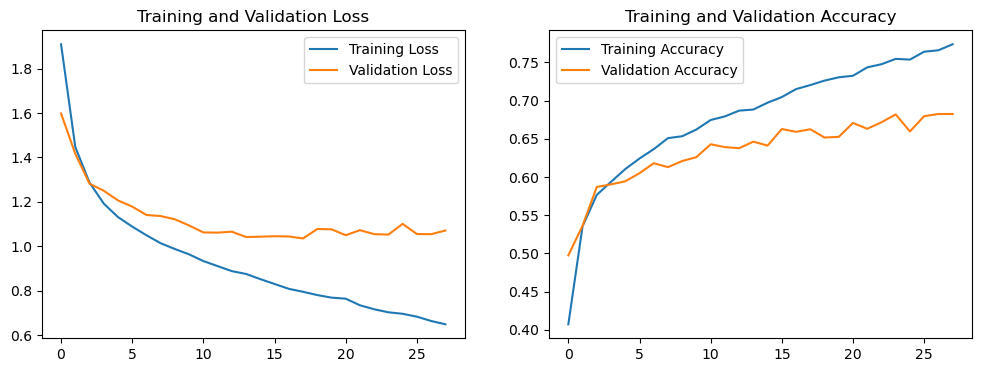

In [25]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()

In [26]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Make predictions and calculate metrics
predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)

# Calculate Precision, Recall, F1-Score
precision = precision_score(y_test, predicted_classes, average='weighted')
recall = recall_score(y_test, predicted_classes, average='weighted')
f1 = f1_score(y_test, predicted_classes, average='weighted')

print(f"Precision: {precision}, Recall: {recall}, F1-Score: {f1}")

print("\n")

# For a detailed classification report including precision, recall, f1-score per class
print(classification_report(y_test, predicted_classes))

110/110 [==============================] - 1s 6ms/step
Precision: 0.6915223750514268, Recall: 0.6824401368301026, F1-Score: 0.6801344700137094


              precision    recall  f1-score   support

           0       0.79      0.66      0.72       221
           1       0.93      1.00      0.96       211
           2       0.56      0.58      0.57       203
           3       0.81      0.60      0.69       236
           4       0.58      0.72      0.65       240
           5       0.85      0.57      0.68       240
           6       0.58      0.77      0.66       196
           7       0.92      0.98      0.95       230
           8       0.77      0.67      0.72       245
           9       0.88      1.00      0.94       204
          10       0.38      0.49      0.43       221
          11       0.53      0.43      0.48       217
          12       0.49      0.51      0.50       223
          13       0.56      0.40      0.47       208
          14       0.54      0.59      0.57 

## Based on this, 28 seems to be the optimal (highest accuracy with the least loss) number of epochs to train the model with.